In [0]:
import pandas as pd
import numpy as np
import torch
import copy
import time
import os
import cv2
import torchvision.transforms.functional as TF
import random

from tqdm import tqdm
from torchvision import models
from torchvision import transforms
from sklearn.metrics import roc_auc_score, f1_score
from torch import nn
from PIL import Image

from matplotlib import pyplot as plt

SEED=np.random.seed(42)

Decode masks function:

In [0]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

Let's look at our data and split it to train and validation:

In [0]:
data_list=pd.read_csv('/content/drive/My Drive/train_masks.csv/train_masks.csv')
print(data_list.head(), '\n', data_list.shape)

                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716... 
 (5088, 2)


In [0]:
data_train=data_list[:4000]
data_test=data_list[4000:]

Dataloader:

In [0]:
def batch_generator(phase, data_tr, data_val, batch_size=10, num_batches=100):
  if phase == 'train':
      data = data_tr
  else:
      data = data_val
    
  # Shuffle our data list
  train_list = (data.iloc[np.random.permutation(len(data))]).reset_index(drop=True)

  for batch in range(num_batches):
      for size in range(batch_size):

        index = batch * batch_size + size # Index of step
        imag, mask_rle = train_list.iloc[index] 
        
        # Read the photo, decode and transform mask into an image, 
        # so that we can use Torch transforms on the mask.
        image = Image.open('/content/drive/My Drive/train/'+ imag)
        mask_rle = rle_decode(mask_rle)
        mask_rle = mask_rle*255
        topil = transforms.ToPILImage()
        mask = topil(mask_rle)

        # Resize
        resize = transforms.Resize(size=(250, 250))
        image = resize(image)
        mask = resize(mask)

        if phase == 'train':
          # Random crop
          i, j, h, w = transforms.RandomCrop.get_params(
              image, output_size=(226, 226))
          image = TF.crop(image, i, j, h, w)
          mask = TF.crop(mask, i, j, h, w)

          # Random horizontal flipping
          if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

          # Random vertical flipping
          if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        else:
          CentralCrop = transforms.CenterCrop(226)
          image = CentralCrop(image)
          mask = CentralCrop(mask)
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        tr_im = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        image = tr_im(image)
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        # Stack batch
        if size == 0: 
            x_batch = image
            y_batch = mask
        else:
            x_batch = torch.cat((x_batch, image),0)
            y_batch = torch.cat((y_batch, mask),0)

        yield x_batch, y_batch


In [0]:
for x,y in batch_generator('val',data_train,data_test, batch_size=4, num_batches=1):
  test=1
y.shape

torch.Size([4, 1, 226, 226])

Now mask contains different values, not just 0 and 1:

In [0]:
np.unique(y)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

That's "green gradient" on the pick

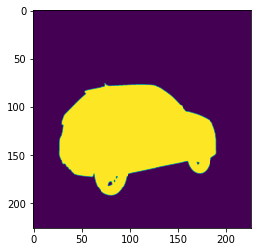

In [0]:
plt.imshow((y[1,:].permute(1,2,0).numpy())[...,0])

A general function to train a model

In [0]:
def train_model(model, criterion, optimizer, data_tr, data_val, num_epochs=3, batch_size=20,num_batches=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_acc = 0.0
    val_acc_history = []
    val_loss_history =[]
    # Initialize the log file for training and testing loss and metrics
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataset_sizes = batch_size*num_batches
            else:
                model.eval()   # Set model to evaluate mode
                dataset_sizes = batch_size*num_batches

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in batch_generator(phase, data_tr, data_val, batch_size,num_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out=model(inputs)
                    outputs = out['out']
                    aux_outputs = out['aux']

                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4*loss2
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

DeeplabHead without adaptive pooling

In [0]:
class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(DeepLabHead, self).__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
            nn.Sigmoid() #Добавим активацию - сигмоиду
        )

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)

class ASPPConv2(nn.Sequential): #Бывший слой адаптивного пулинга, просто вырезал его, сделав обычный конв слой 🤷‍♀️🤷‍♀️🤷‍♀️
    def __init__(self, in_channels, out_channels,):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv2, self).__init__(*modules)



class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rate1, rate2, rate3 = tuple(atrous_rates)
        modules.append(ASPPConv(in_channels, out_channels, rate1))
        modules.append(ASPPConv(in_channels, out_channels, rate2))
        modules.append(ASPPConv(in_channels, out_channels, rate3))
        modules.append(ASPPConv2(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))
    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


Function to create model

In [0]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Sigmoid activation after the last convolution layer
    model.classifier = DeepLabHead(2048, 1)
    # Set the model in training mode
    model.train()
    return model

Edit aux classifier too

In [0]:
conv=torch.nn.Conv2d(
    in_channels=256,
    out_channels=1,
    kernel_size=(1, 1),
    stride=(1, 1)
                ).cuda() # change output channels to 1

#if need sigmoid as last layer
#sigma=torch.nn.Sigmoid()

model.aux_classifier[4]=conv
#model.aux_classifier=nn.Sequential(*list(modelz.aux_classifier)+[sigma]) 

Parameters

In [0]:
# Loss function
criterion = nn.BCEWithLogitsLoss()
# Optimizer and learning rate
optimizer = torch.optim.Adam(modelz.parameters(), lr=1e-4)
                            

In [0]:
trained_model,acc,lss = train_model(model, criterion, optimizer, data_train,data_test, num_epochs=10, batch_size=4,num_batches=250)

Epoch 1/10
----------
train Loss: 0.0493 Acc: 280729.2080
val Loss: 0.0502 Acc: 278977.1350

Epoch 2/10
----------
train Loss: 0.0490 Acc: 279643.0700
val Loss: 0.0491 Acc: 279603.9780

Epoch 3/10
----------
train Loss: 0.0476 Acc: 280947.7200
val Loss: 0.0492 Acc: 280174.1960

Epoch 4/10
----------
train Loss: 0.0477 Acc: 281139.3150
val Loss: 0.0496 Acc: 279431.6960

Epoch 5/10
----------
train Loss: 0.0469 Acc: 280836.2090
val Loss: 0.0491 Acc: 279630.3680

Epoch 6/10
----------
train Loss: 0.0477 Acc: 279760.7920
val Loss: 0.0485 Acc: 279810.6360

Epoch 7/10
----------
train Loss: 0.0477 Acc: 280240.4110
val Loss: 0.0487 Acc: 279212.7390

Epoch 8/10
----------
train Loss: 0.0466 Acc: 281246.5340
val Loss: 0.0485 Acc: 279348.7320

Epoch 9/10
----------
train Loss: 0.0457 Acc: 281926.1870
val Loss: 0.0484 Acc: 280051.4890

Epoch 10/10
----------
train Loss: 0.0463 Acc: 281165.9650
val Loss: 0.0485 Acc: 279638.1120

Training complete in 89m 15s
Best val loss: 0.048394
Best val Acc: 28

In [71]:
result=data=pd.read_csv('/content/drive/My Drive/results.csv')
result.head()

,1 loss,1 acc,2 loss,2 acc,3 loss,3 acc,4 loss,4 acc
0,0.171782,279207.963,0.181256,281091.0750,0.398137,281172.8679,0.086091,283747.769
1,0.133206,279460.120,0.130678,278297.2964,0.338455,281554.5214,0.064168,283524.488
2,0.126858,279659.508,0.094296,279393.7250,0.295681,281160.6821,0.065812,283518.185
3,0.124516,280018.987,0.082050,280118.4750,0.275486,278836.7643,0.060538,283528.230
4,0.126851,279408.764,0.074159,280545.1500,0.231126,279210.5250,0.057858,283452.624


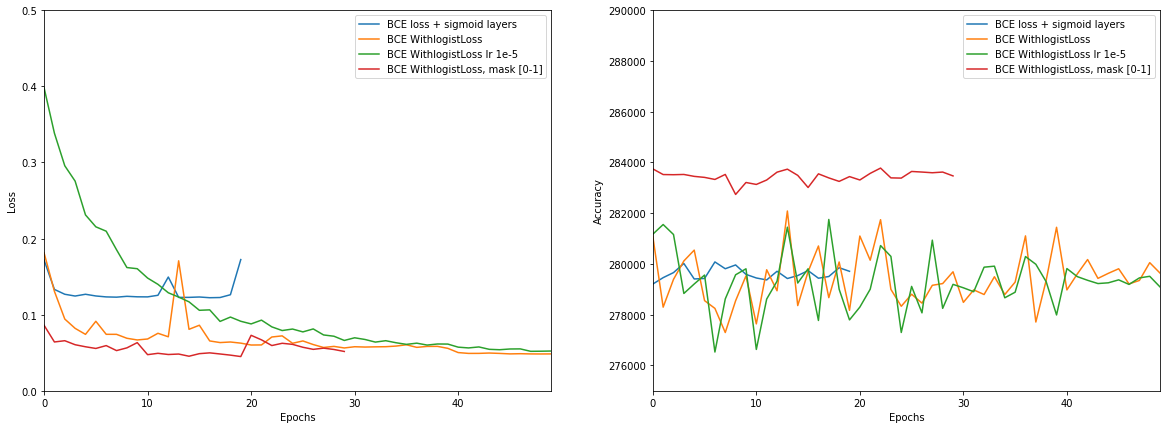

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))
#plt.subplots(figsize=(12,7))
axs[0].plot(result['1 loss'], '-', label='BCE loss + sigmoid layers')
axs[0].plot(result['2 loss'], '-', label='BCE WithlogistLoss')
axs[0].plot(result['3 loss'], '-', label='BCE WithlogistLoss lr 1e-5')
axs[0].plot(result['4 loss'], '-', label='BCE WithlogistLoss, mask [0-1]')
axs[1].plot(result['1 acc'], '-', label='BCE loss + sigmoid layers')
axs[1].plot(result['2 acc'], '-', label='BCE WithlogistLoss')
axs[1].plot(result['3 acc'], '-', label='BCE WithlogistLoss lr 1e-5')
axs[1].plot(result['4 acc'], '-', label='BCE WithlogistLoss, mask [0-1]')
#plt.title('Results')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()
axs[0].set_xlim(0,49)
axs[0].set_ylim(0,0.5)
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_xlim(0,49)
axs[1].set_ylim(275000,290000)
axs[1].legend()
plt.show()

Function for test model and illustrate results

In [0]:
def test_model(model, number=0, way='/content/drive/My Drive/test/'):
    data=pd.read_csv('/content/drive/My Drive/test/test.csv')
    img_name = data.iloc[number,0]

    imagea = Image.open(way + img_name)
    #imagea = Image.open('/content/drive/My Drive/IMG_20190831_002834.jpg')
    h,w,c=np.array(imagea).shape
    resize = transforms.Resize(size=(250, 250))
    imager = resize(imagea)

    trf = transforms.Compose([#transforms.Resize(250),
                              transforms.ToTensor(), 
                              transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                              std = [0.229, 0.224, 0.225])])
    
  
    image= trf(imager)
    image = image.unsqueeze(0).cuda()
    mas = model(image)['out']
    
    masks = mas.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    masks = 1/(1 + np.exp(-masks)) #sigmoid for BCEWithLogistLoss
    mask = cv2.resize(masks,(w,h))
    imager = cv2.resize(np.array(imager), (w, h))
    
    fig, axs = plt.subplots(1, 3, figsize=(22,5))

    #plot the original data
    axs[0].imshow(imagea,aspect=1) 
    axs[0].axis('off')
    axs[0].set_title('Image')

    #plot the mask
    axs[1].imshow((mask>0.5),aspect=1)
    axs[1].axis('off')   
    axs[1].set_title('Mask')
    
    #plot image and add the mask
    axs[2].imshow(imager)
    axs[2].imshow((mask>0.5), alpha = 0.5, cmap = "Reds")
    axs[2].axis('off')   
    axs[2].set_title('Image with mask overlay')

    # set suptitle
    #plt.suptitle('Image with mask')
    return plt.show()

In [0]:
def load_model(number = 2):
    if number == 1:
      model = torch.load('/content/drive/My Drive/Model_BCE_Sigm.pth')
    elif number == 2:
      model = torch.load('/content/drive/My Drive/Model_2.pth')
    elif number == 3:
      model = torch.load('/content/drive/My Drive/Model_3.pth')
    else:
      model = torch.load('/content/drive/My Drive/Model_4.pth')
    model.eval().cuda()
    return model  

In [0]:
model4 = load_model(32)
model1 = load_model(1)
model2 = load_model(2)
model3 = load_model(3)

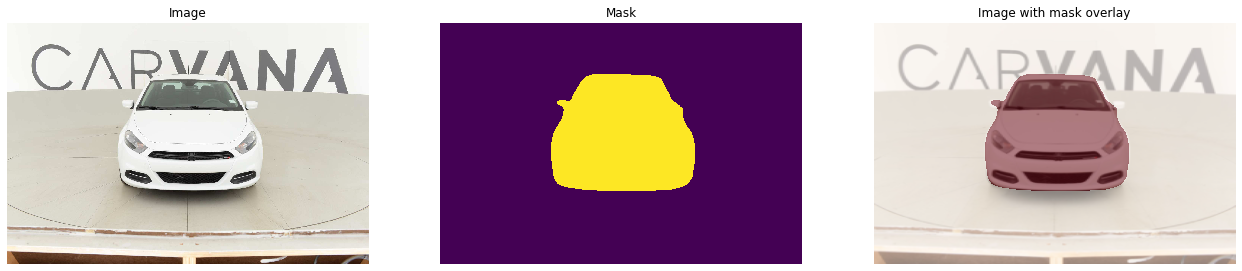

In [11]:
test_model(model4, number = 31)

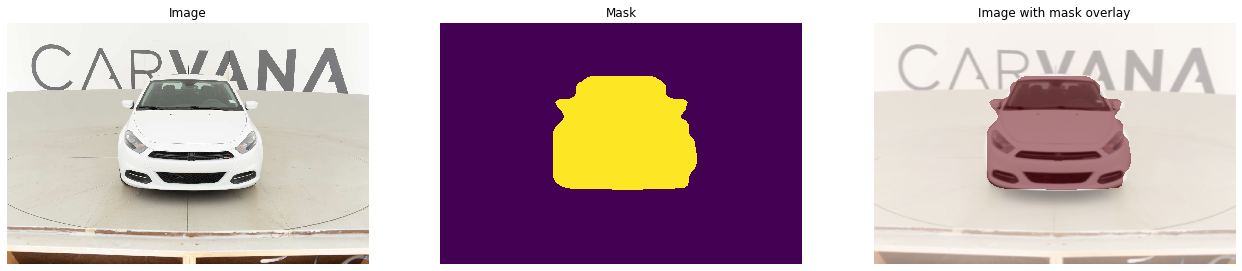

In [17]:
test_model(model1, number = 31)

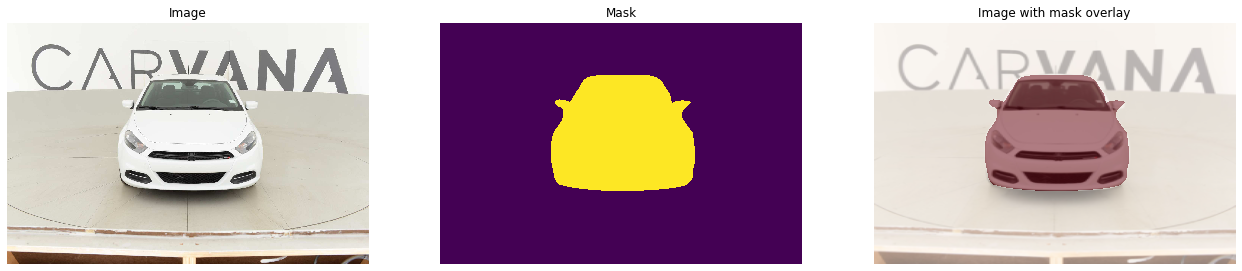

In [16]:
test_model(model3, number = 31)

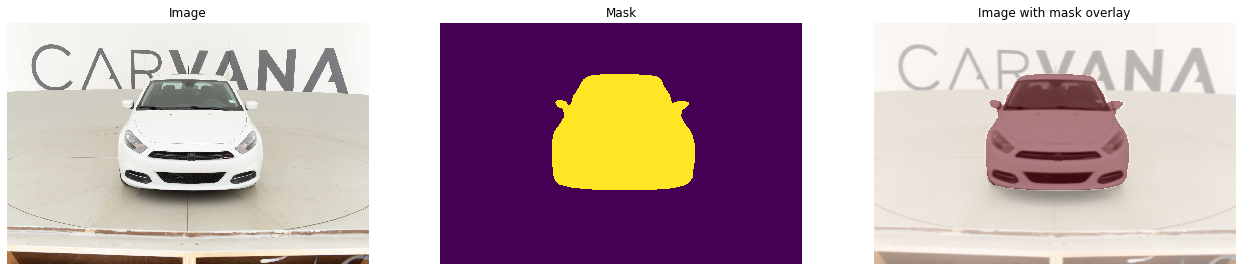

In [15]:
test_model(model2, number = 31)

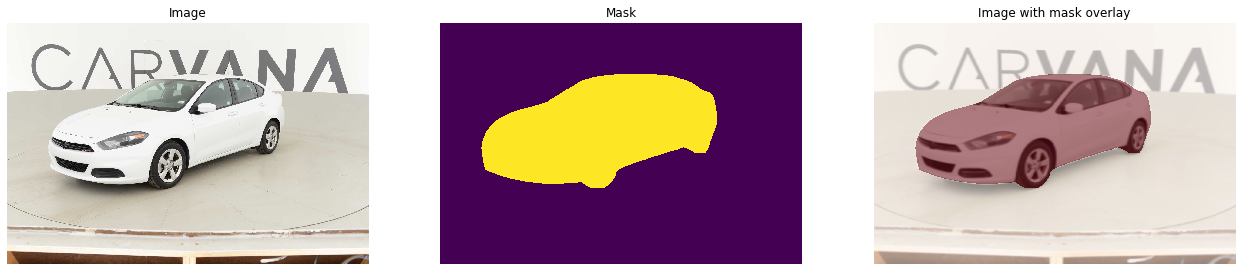

In [14]:
test_model(model2, number = 32)

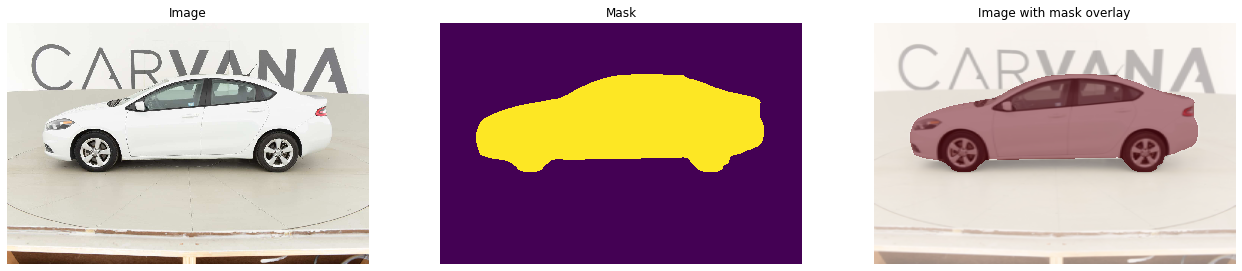

In [18]:
test_model(model2, number = 33)

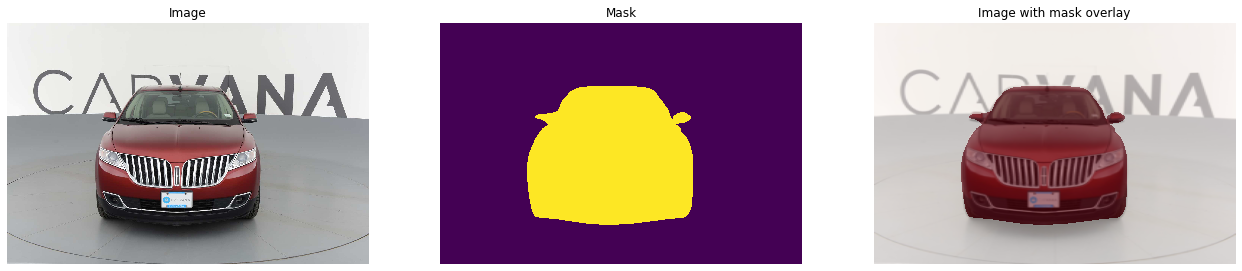

In [19]:
test_model(model3, number = 34)

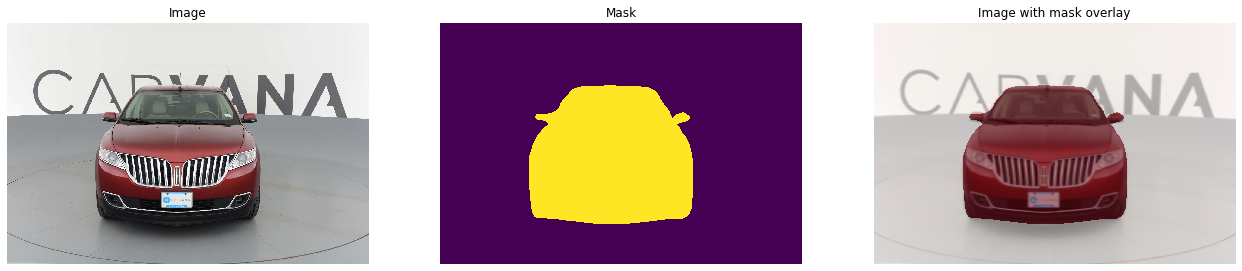

In [20]:
test_model(model2, number = 34)

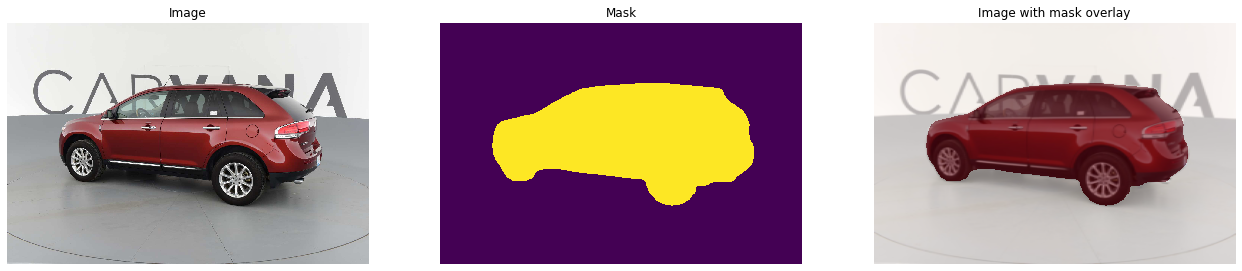

In [64]:
test_model(model2, number = 36)

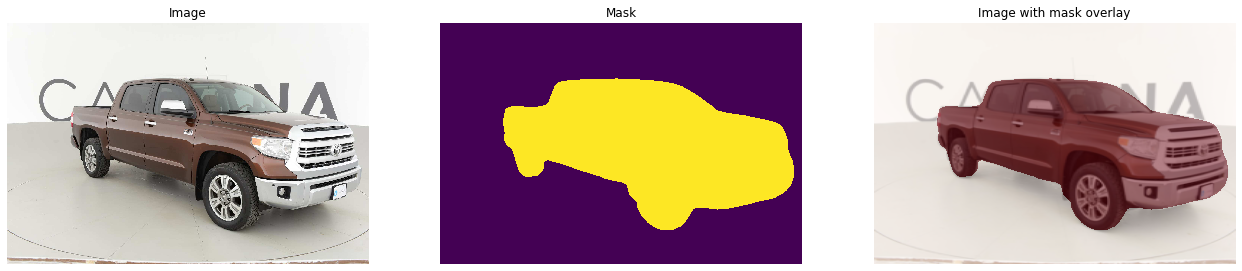

In [69]:
test_model(model2, number = 14)

In [0]:
original = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True).cuda().eval()

In [0]:
def test_model_orig(model, number=0, way='/content/drive/My Drive/test/'):
    data=pd.read_csv('/content/drive/My Drive/test/test.csv')
    img_name = data.iloc[number,0]

    imagea = Image.open(way + img_name)
    #imagea = Image.open('/content/drive/My Drive/IMG_20190831_002834.jpg')
    h,w,c=np.array(imagea).shape
            # Resize
    resize = transforms.Resize(size=(250, 250))
    imager = resize(imagea)

    trf = transforms.Compose([#transforms.Resize(250),
                              transforms.ToTensor(), 
                              transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                              std = [0.229, 0.224, 0.225])])
    
  
    image= trf(imager)
    image = image.unsqueeze(0).cuda()
    mas = model(image)['out']
    
    mas = torch.argmax(mas.squeeze(), dim=0).detach().cpu().numpy()

    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (128, 128, 128), (255, 0, 0), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(mas).astype(np.uint8)
    g = np.zeros_like(mas).astype(np.uint8)
    b = np.zeros_like(mas).astype(np.uint8)
  
    for l in range(0, 21):
      idx = mas == l
      r[idx] = label_colors[l, 0]
      g[idx] = label_colors[l, 1]
      b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)

    mask = cv2.resize(rgb,(w,h))
    imager = cv2.resize(np.array(imager), (w, h))
    
    fig, axs = plt.subplots(1, 3, figsize=(22,5))

    #plot the original data
    axs[0].imshow(imagea,aspect=1) 
    axs[0].axis('off')
    axs[0].set_title('Image')

    #plot the mask
    axs[1].imshow((mask),aspect=1)
    axs[1].axis('off')   
    axs[1].set_title('Mask')
    
    #plot image and add the mask
    axs[2].imshow(imager)
    axs[2].imshow((mask), alpha = 0.5, cmap = "Reds")
    axs[2].axis('off')   
    axs[2].set_title('Image with mask overlay')

    # set suptitle
    #plt.suptitle('Image with mask')
    return plt.show()

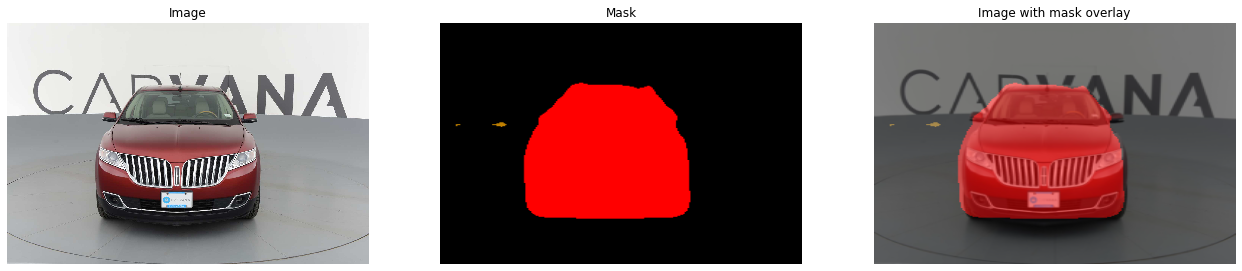

In [65]:
test_model_orig(original, number = 34)

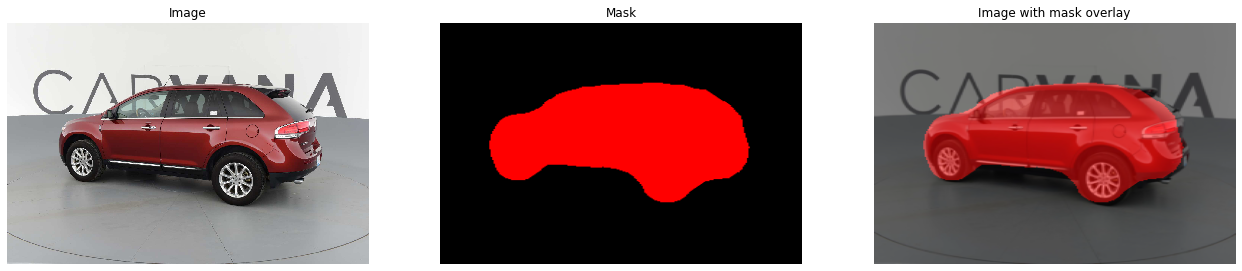

In [66]:
test_model_orig(original, number = 36)

In [0]:
def save_model(model):
    torch.save(model, '/content/drive/My Drive/extralastez1.pth')

In [0]:
save_model(model)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DeepLabHead. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ASPP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ASPPConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ASPPConv2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
